In [1]:
import cv2
import PIL
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import datasets
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from scipy.signal import savgol_filter
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, Sampler

Train size: 60000, Test size: 10000

Label: 2


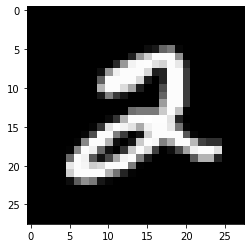

In [2]:
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True)
print(f'Train size: {len(mnist_train)}, Test size: {len(mnist_test)}\n')
sample = mnist_train[5]
image = sample[0]
label = sample[1]
print(f'Label: {label}')
plt.imshow(image, cmap='gray')
plt.show()

In [3]:
class Configs:
    def __init__(self, n_epochs=5, batch_size=64, test_batch_size=1000, learning_rate=0.01, momentum=0.8, log_interval=1000):
        torch.manual_seed(9)
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.log_interval = log_interval

        self.train_configs = {'batch_size': self.batch_size}
        self.val_configs = {'batch_size': self.batch_size}
        self.test_configs = {'batch_size': self.test_batch_size}
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            cuda_configs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True, 'drop_last': True}
            self.train_configs.update(cuda_configs)
            self.val_configs.update(cuda_configs)
            self.test_configs.update(cuda_configs)

        else:
            self.device = torch.device("cpu")
            cpu_configs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
            self.train_configs.update(cpu_configs)
            self.val_configs.update(cpu_configs)
            self.test_configs.update(cpu_configs)
    
    def get_train_kwargs(self):
        return self.train_configs

    def get_val_kwargs(self):
        return self.val_configs
    
    def get_test_kwargs(self):
        return self.test_configs

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        output = self.fc2(x)
        return output

def train(configs, model, train_loader, optimizer, epoch, criterion):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(configs.device), target.to(configs.device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx == len(train_loader) - 1:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return losses

def validate(model, configs, val_loader, criterion, epoch):
    losses = []
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(configs.device), target.to(configs.device)
            output = model(data)
            loss = criterion(output, target).item()
            val_loss += loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            losses.append(loss)
    val_loss /= len(val_loader)
    print(f'Epoch {epoch}: Validation Average Loss: {val_loss:.4f}; Validation Average Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)')
    return losses, 100. * correct / len(val_loader.dataset)

def test(model, configs, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(configs.device), target.to(configs.device)
            output = model(data)
            loss = criterion(output, target).item()
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print(f'\nTest Average Loss: {test_loss:.4f}; Test Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')


In [4]:
# define data transformation
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# load, preprocess, and split dataset
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=transformer)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=transformer)
mnist_train, mnist_val = random_split(mnist_train, [int(len(mnist_train) * 0.8), int(len(mnist_train) * 0.2)])


In [5]:
# define model configs
configs = Configs(n_epochs=10, batch_size=64, test_batch_size=1000, learning_rate=0.01, momentum=0.9, log_interval=None)

# load config
model = Net().to(configs.device)

# define loss function
criterion = CrossEntropyLoss()

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=configs.learning_rate, momentum=configs.momentum)

# load dataset
train_loader = DataLoader(mnist_train, **configs.get_train_kwargs())
val_loader = DataLoader(mnist_val, **configs.get_val_kwargs())
test_loader = DataLoader(mnist_test, **configs.get_test_kwargs())
# start training
train_losses_epoch = []
val_losses_epoch = []
val_accuracies = []
for epoch in range(configs.n_epochs):
    # train
    train_losses = train(configs, model, train_loader, optimizer, epoch, criterion)
    train_losses_epoch.append(np.mean(train_losses))

    # validate
    validation_losses, val_accuracy = validate(model, configs, val_loader, criterion, epoch)
    val_losses_epoch.append(np.mean(validation_losses))
    val_accuracies.append(val_accuracy)

In [ ]:
# inference
test(model, configs, test_loader, criterion)

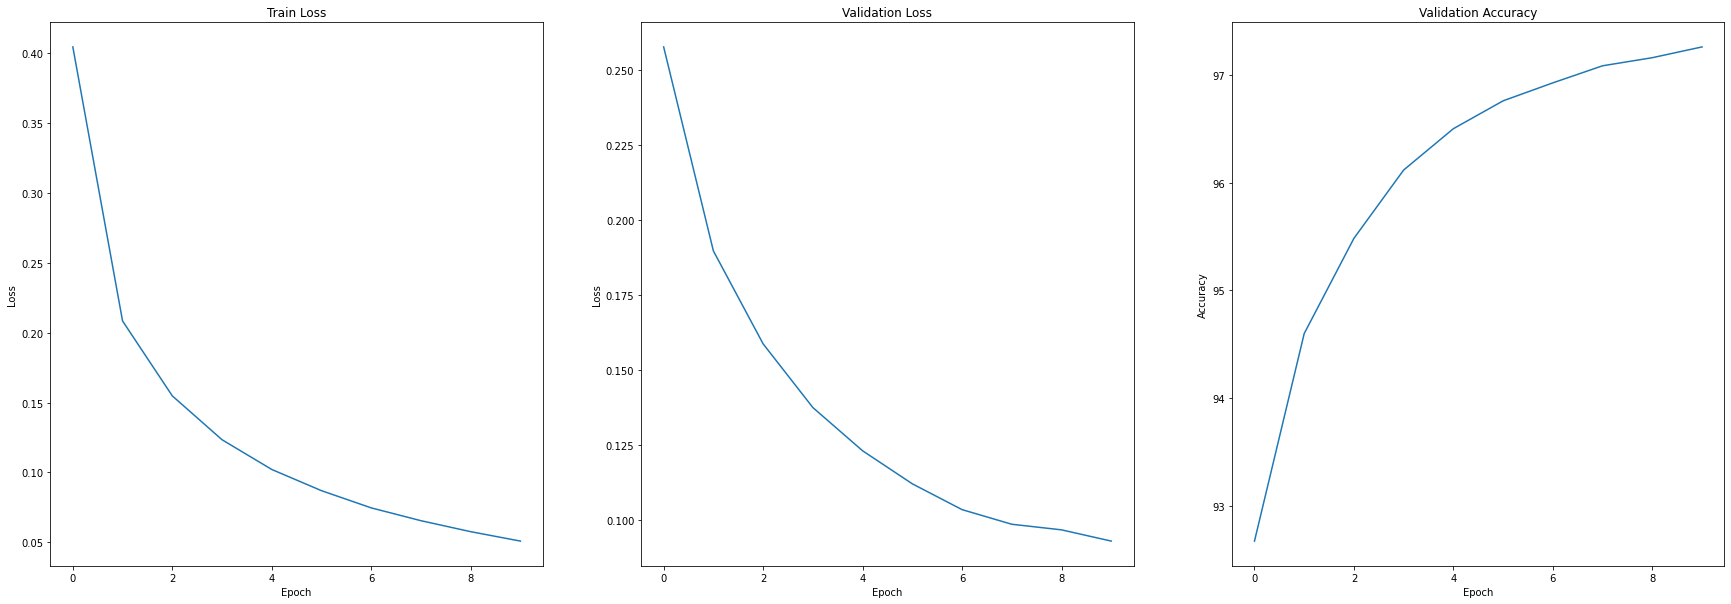

In [152]:

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].plot(np.arange(len(train_losses_epoch)), train_losses_epoch)
ax[0].title.set_text('Train Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(np.arange(len(val_losses_epoch)), val_losses_epoch)
ax[1].title.set_text('Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[2].plot(np.arange(len(val_accuracies)), val_accuracies)
ax[2].title.set_text('Validation Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
plt.show()

In [138]:
5000/70000

0.07142857142857142